In [53]:
# %% minimal bootstrap
import sys, os, subprocess, importlib.util
from pathlib import Path

def find_project_root(start: Path) -> Path:
    p = start.resolve()
    for _ in range(50):
        if any((p / m).exists() for m in ("pyproject.toml", ".git", "defaults.yaml")):
            return p
        if p == p.parent: break
        p = p.parent
    return start.resolve()

_here = Path(__file__).resolve() if "__file__" in globals() else Path.cwd().resolve()
ROOT = find_project_root(_here)
os.chdir(ROOT)
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

def ensure_editable_installed(pkg_name: str, pkg_dir: Path):
    spec = importlib.util.find_spec(pkg_name)
    need = (not spec) or (not getattr(spec, "origin", None)) or (Path(spec.origin).resolve().parents[0] != pkg_dir.resolve())
    if need:
        print(f"Installing {pkg_name} in editable mode from {pkg_dir} ...")
        subprocess.run([sys.executable, "-m", "pip", "install", "-e", str(pkg_dir)], check=True)
    else:
        print(f"{pkg_name} already installed from this repo.")

ensure_editable_installed("diffinst", ROOT / "diffinst")

diffinst already installed from this repo.


In [54]:
# %% imports & paths
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from diffinst import Config
from diffinst.linear_ops import evp_solve_at_k
from diffinst.analysis_api import (
    load_manifest, load_config_from_run, list_checkpoints, load_metrics,
    load_linear_run, load_linear_Sigma_series, load_linear_amplitude,
    load_nonlinear_run, load_nonlinear_Sigma_series, load_nonlinear_amplitude,
    nearest_k_index, save_ic_npz, evp_gamma
)


EXP_GAS = ROOT / "experiments" / "unstable_baseline.yaml"
EXP_DUST = ROOT / "experiments" / "unstable_baseline_dustonly.yaml"
DEFAULTS     = ROOT / "defaults.yaml"
RUNS         = ROOT / "runs"; RUNS.mkdir(exist_ok=True)

print("project root:", ROOT)

project root: /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst


In [55]:
# %% shared simulation parameters
k_phys      = 100.0
amp_phys    = 1e-6
Nx_ic       = 128
exact_harm  = 2      # 2 wavelengths in the box, as before

stop_time   = 10.0
dt          = 1e-3
save_stride = 200

# Run directories
RUN_GAS_IC   = RUNS / "ic_k100_gas.npz"
RUN_DUST_IC  = RUNS / "ic_k100_dust.npz"

RUN_GAS_LIN  = RUNS / "lin_from_ic_gas"
RUN_GAS_NL   = RUNS / "nl_from_ic_gas"
RUN_DUST_LIN = RUNS / "lin_from_ic_dust"
RUN_DUST_NL  = RUNS / "nl_from_ic_dust"

RUN_GAS_LIN.mkdir(exist_ok=True)
RUN_GAS_NL.mkdir(exist_ok=True)
RUN_DUST_LIN.mkdir(exist_ok=True)
RUN_DUST_NL.mkdir(exist_ok=True)

NONLINEAR_MODE = "nonlinear"

print("k =", k_phys)

k = 100.0


In [56]:
# %% helper for CLI calls
import shlex, subprocess

def run_cmd(cmd: str):
    print(">>", cmd)
    result = subprocess.run(
        shlex.split(cmd),
        cwd=ROOT,
        capture_output=True,
        text=True,
    )
    if result.stdout:
        print(result.stdout)
    if result.stderr:
        print(result.stderr)
    if result.returncode != 0:
        raise RuntimeError(f"Command failed with code {result.returncode}")

In [57]:
# %% build eigenmode ICs (gas vs dust) via CLI

# Gas-inclusive IC
run_cmd(
    f"python -m scripts.make_ic_eigen "
    f"--config {EXP_GAS} "
    f"--out {RUN_GAS_IC} "
    f"--k {k_phys} "
    f"--amp {amp_phys} "
    f"--Nx {Nx_ic} "
    f"--exact-fit-harm {exact_harm}"
)

# Dust-only IC
run_cmd(
    f"python -m scripts.make_ic_eigen "
    f"--config {EXP_DUST} "
    f"--out {RUN_DUST_IC} "
    f"--k {k_phys} "
    f"--amp {amp_phys} "
    f"--Nx {Nx_ic} "
    f"--exact-fit-harm {exact_harm}"
)

>> python -m scripts.make_ic_eigen --config /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/experiments/unstable_baseline.yaml --out /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/ic_k100_gas.npz --k 100.0 --amp 1e-06 --Nx 128 --exact-fit-harm 2
[make_ic_eigen] IC written to /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/ic_k100_gas.npz (k=100.0, amp=1e-06, Nx=128)

>> python -m scripts.make_ic_eigen --config /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/experiments/unstable_baseline_dustonly.yaml --out /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/ic_k100_dust.npz --k 100.0 --amp 1e-06 --Nx 128 --exact-fit-harm 2
[make_ic_eigen] IC written to /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/ic_k100_dust.npz (k=100.0, amp=1e-06, Nx=128)



In [58]:
# %% run linear TD from eigenmode ICs (gas vs dust)

# Gas-inclusive
run_cmd(
    f"python -m scripts.run_linear "
    f"--config {EXP_GAS} "
    f"--outdir {RUN_GAS_LIN} "
    f"--mode linear "
    f"--dt {dt} "
    f"--stop_time {stop_time} "
    f"--save-stride {save_stride} "
    f"--init-from {RUN_GAS_IC}"
)

# Dust-only
run_cmd(
    f"python -m scripts.run_linear "
    f"--config {EXP_DUST} "
    f"--outdir {RUN_DUST_LIN} "
    f"--mode linear "
    f"--dt {dt} "
    f"--stop_time {stop_time} "
    f"--save-stride {save_stride} "
    f"--init-from {RUN_DUST_IC}"
)

>> python -m scripts.run_linear --config /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/experiments/unstable_baseline.yaml --outdir /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/lin_from_ic_gas --mode linear --dt 0.001 --stop_time 10.0 --save-stride 200 --init-from /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/ic_k100_gas.npz
[linear] done: {'t_final': 10.0, 'steps': 10001, 'Nx': 128, 'Lx': 0.12566370614359174}

>> python -m scripts.run_linear --config /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/experiments/unstable_baseline_dustonly.yaml --outdir /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/lin_from_ic_dust --mode linear --dt 0.001 --stop_time 10.0 --save-stride 200 --init-from /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/ic_k100_dust.npz
[linear] done: {'t_final': 10.0, 'steps': 10001, 'Nx': 128, 'Lx': 0.12566370614359174}



In [59]:
# %% nonlinear TD: gas-inclusive config, eigenmode IC
# Make sure you've created RUN_GAS_IC earlier with make_ic_eigen

! python -m scripts.run_nonlinear \
  --config experiments/unstable_baseline.yaml \
  --outdir runs/nl_from_ic_gas \
  --mode nonlinear \
  --dt 1e-3 \
  --stop_time 10 \
  --save-stride 200 \
  --init-from runs/ic_k100_gas.npz \
  --Nx 128 \
  --print-stride 400 \
  --force

[INFO] Removing existing output directory: runs/nl_from_ic_gas
/Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/diffinst/nonlinear_terms.py:75: RuntimeWarning: overflow encountered in multiply
  dSigma_dt = -ops.dx(Sigma * vx)
/opt/anaconda3/envs/dedalus3/lib/python3.13/site-packages/numpy/fft/_pocketfft.py:101: RuntimeWarning: invalid value encountered in rfft_n_even
  return ufunc(a, fct, axes=[(axis,), (), (axis,)], out=out)
/Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/diffinst/nonlinear_terms.py:78: RuntimeWarning: overflow encountered in multiply
  term_D_nl      = -invS * ops.dx((D * D / Sigma) * (dSdx * dSdx))
/Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/diffinst/nonlinear_terms.py:78: RuntimeWarning: invalid value encountered in multiply
  term_D_nl      = -invS * ops.dx((D * D / Sigma) * (dSdx * dSdx))
/Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/diffinst/nonlinear_terms.py:82: RuntimeWarni

In [60]:
# %% nonlinear TD: dust-inclusive config, eigenmode IC

! python -m scripts.run_nonlinear \
  --config experiments/unstable_baseline_dustonly.yaml \
  --outdir runs/nl_from_ic_dust \
  --mode nonlinear \
  --dt 1e-3 \
  --stop_time 10 \
  --save-stride 200 \
  --init-from runs/ic_k100_dust.npz \
  --Nx 128 \
  --print-stride 400 \
  --force

[INFO] Removing existing output directory: runs/nl_from_ic_dust
2025-11-21 11:49:11,952 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=400  t=4.000000e-01  dt=1.000e-03
2025-11-21 11:49:12,276 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=800  t=8.000000e-01  dt=1.000e-03
2025-11-21 11:49:12,596 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=1200  t=1.200000e+00  dt=1.000e-03
2025-11-21 11:49:12,926 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=1600  t=1.600000e+00  dt=1.000e-03
2025-11-21 11:49:13,250 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=2000  t=2.000000e+00  dt=1.000e-03
2025-11-21 11:49:13,571 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=2400  t=2.400000e+00  dt=1.000e-03
2025-11-21 11:49:13,892 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=2800  t=2.800000e+00  dt=1.000e-03
2025-11-21 11:49:14,212 diffinst.solvers.native_nonlinear INFO :: Native nonl

In [61]:
# %% EVP growth rates for gas-inclusive and dust-only
cfg_gas  = Config.from_yaml(EXP_GAS, DEFAULTS)
cfg_dust = Config.from_yaml(EXP_DUST, DEFAULTS)

gamma_gas  = evp_gamma(cfg_gas,  k_phys)
gamma_dust = evp_gamma(cfg_dust, k_phys)

print(f"EVP gamma (gas)  @ k={k_phys}: {gamma_gas:.6g}")
print(f"EVP gamma (dust) @ k={k_phys}: {gamma_dust:.6g}")

EVP gamma (gas)  @ k=100.0: 0.155249
EVP gamma (dust) @ k=100.0: 0.0516357


In [62]:
# %% load |Sigma_k| vs t from runs
TL_gas,  AL_gas  = load_linear_amplitude(RUN_GAS_LIN,  k_phys)
TL_dust, AL_dust = load_linear_amplitude(RUN_DUST_LIN, k_phys)

TN_gas,  AN_gas  = load_nonlinear_amplitude(RUN_GAS_NL,  k_phys)
TN_dust, AN_dust = load_nonlinear_amplitude(RUN_DUST_NL, k_phys)

print("Loaded amplitudes:")
print("  GAS  linear:",  len(TL_gas),  "steps")
print("  GAS  nonlin:",  len(TN_gas),  "steps")
print("  DUST linear:",  len(TL_dust), "steps")
print("  DUST nonlin:",  len(TN_dust), "steps")

Loaded amplitudes:
  GAS  linear: 52 steps
  GAS  nonlin: 52 steps
  DUST linear: 52 steps
  DUST nonlin: 52 steps


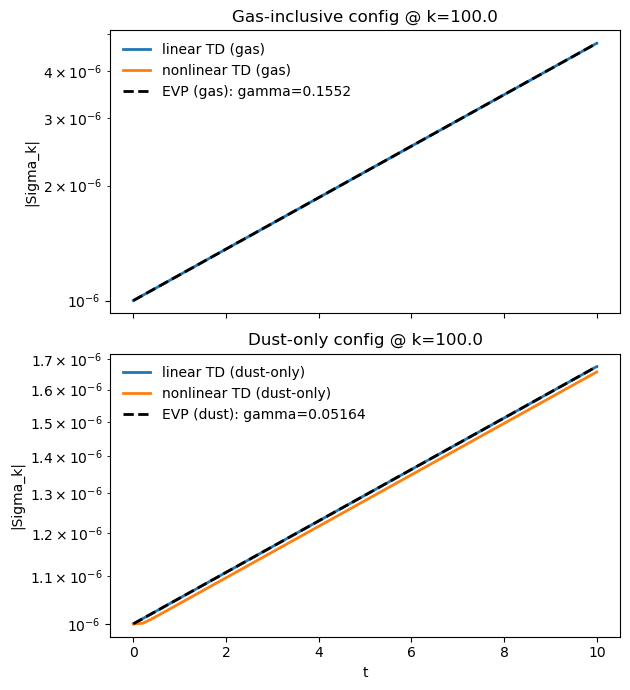

In [63]:
# %% plot gas-inclusive vs dust-only, linear vs nonlinear vs EVP
fig, axes = plt.subplots(2, 1, figsize=(6.4, 7.0), sharex=True)

# --- GAS-INCLUSIVE ---
ax = axes[0]
ax.plot(TL_gas, AL_gas,  label="linear TD (gas)", lw=2)
ax.plot(TN_gas, AN_gas,  label="nonlinear TD (gas)", lw=2)

A0_gas = AL_gas[0]
ax.plot(
    TL_gas,
    A0_gas * np.exp(gamma_gas * (TL_gas - TL_gas[0])),
    "k--",
    lw=2,
    label=f"EVP (gas): gamma={gamma_gas:.4g}"
)

ax.set_yscale("log")
ax.set_ylabel("|Sigma_k|")
ax.set_title(f"Gas-inclusive config @ k={k_phys}")
ax.legend(frameon=False)

# --- DUST-ONLY ---
ax = axes[1]
ax.plot(TL_dust, AL_dust, label="linear TD (dust-only)", lw=2)
ax.plot(TN_dust, AN_dust, label="nonlinear TD (dust-only)", lw=2)

A0_dust = AL_dust[0]
ax.plot(
    TL_dust,
    A0_dust * np.exp(gamma_dust * (TL_dust - TL_dust[0])),
    "k--",
    lw=2,
    label=f"EVP (dust): gamma={gamma_dust:.4g}"
)

ax.set_yscale("log")
ax.set_xlabel("t")
ax.set_ylabel("|Sigma_k|")
ax.set_title(f"Dust-only config @ k={k_phys}")
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

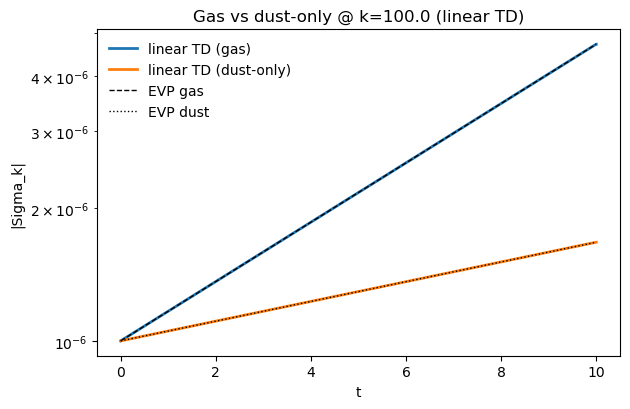

In [64]:
# %% optional: overlay gas vs dust (linear TD only)
fig, ax = plt.subplots(figsize=(6.4, 4.2))

ax.plot(TL_gas,  AL_gas,  lw=2, label="linear TD (gas)")
ax.plot(TL_dust, AL_dust, lw=2, label="linear TD (dust-only)")

A0g = AL_gas[0]
A0d = AL_dust[0]
ax.plot(TL_gas,  A0g * np.exp(gamma_gas  * (TL_gas  - TL_gas[0])),  "k--", lw=1, label="EVP gas")
ax.plot(TL_dust, A0d * np.exp(gamma_dust * (TL_dust - TL_dust[0])), "k:",  lw=1, label="EVP dust")

ax.set_yscale("log")
ax.set_xlabel("t")
ax.set_ylabel("|Sigma_k|")
ax.set_title(f"Gas vs dust-only @ k={k_phys} (linear TD)")
ax.legend(frameon=False)
plt.tight_layout()
plt.show()